<a href="https://colab.research.google.com/github/Sindhee/IIRS_ISRO_Internship_Project/blob/main/simplified_resnet_unet_arch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import rasterio
import os
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    def __init__(self,
                 image_folder,
                 mask_folder,
                 target_size=(256, 256),
                 test_size=0.3,
                 val_split=0.5,
                 max_files=1000):
        """
        Initialize data preprocessor for building extraction dataset.

        Args:
            image_folder (str): Path to satellite image TIFF files
            mask_folder (str): Path to mask TIFF files
            target_size (tuple): Desired image and mask dimensions
            test_size (float): Proportion of data to reserve for testing
            val_split (float): Proportion of test data to use for validation
            max_files (int): Maximum number of files to use
        """
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.target_size = target_size
        self.test_size = test_size
        self.val_split = val_split
        self.max_files = max_files

        # Sort and limit the number of files to `max_files`
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.tif', '.tiff'))])[:max_files]
        self.mask_files = sorted([f for f in os.listdir(mask_folder) if f.lower().endswith(('.tif', '.tiff'))])[:max_files]



    def load_tiff_dataset(self):
        """
        Load TIFF images and masks, handling potential errors.

        Returns:
            tuple: Numpy arrays of images and masks
        """
        all_images = []
        all_masks = []

        for img_file, mask_file in zip(self.image_files, self.mask_files):
            try:
                # Load image (RGB channels)
                with rasterio.open(os.path.join(self.image_folder, img_file)) as src:
                    img_array = src.read([1, 2, 3])
                    img_array = np.moveaxis(img_array, 0, -1)

                # Load mask
                with rasterio.open(os.path.join(self.mask_folder, mask_file)) as src:
                    mask_array = src.read(1)

                all_images.append(img_array)
                all_masks.append(mask_array)

            except Exception as e:
                print(f"Error processing {img_file} or {mask_file}: {e}")

        return np.array(all_images), np.array(all_masks)

    def preprocess_data(self, images, masks):
      processed_images = []
      processed_masks = []

      for img, mask in zip(images, masks):
          if np.any(np.isnan(img)) or np.any(np.isnan(mask)):
              print("NaN detected in input, skipping...")
              continue

          # Resize image
          resized_img = tf.image.resize(
              img,
              self.target_size,
              method=tf.image.ResizeMethod.BILINEAR
          ).numpy()

          # Resize mask
          resized_mask = tf.image.resize(
              mask[..., np.newaxis],
              self.target_size,
              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
          ).numpy().squeeze()

          # Normalize image
          normalized_img = np.clip(resized_img.astype('float32') / 255.0, 0, 1)

          # Normalize mask (binary)
          normalized_mask = np.clip((resized_mask > 0).astype('float32'), 0, 1)

          processed_images.append(normalized_img)
          processed_masks.append(normalized_mask)
          print(f"Image shape before resizing: {img.shape}")
          print(f"Mask shape before resizing: {mask.shape}")
          print(f"Image shape after resizing: {resized_img.shape}")
          print(f"Mask shape after resizing: {resized_mask.shape}")

      print(f"Preprocessed images shape: {np.array(processed_images).shape}")
      print(f"Preprocessed masks shape: {np.array(processed_masks).shape}")

      return np.array(processed_images), np.array(processed_masks)



    def split_dataset(self, images, masks):
        """
        Split dataset into train, validation, and test sets.

        Args:
            images (np.array): Preprocessed images
            masks (np.array): Preprocessed masks

        Returns:
            dict: Dictionary containing split datasets
        """
        # First split: train vs test
        train_images, temp_images, train_masks, temp_masks = train_test_split(
            images, masks, test_size=self.test_size, random_state=42
        )

        # Second split: validation from test set
        val_images, test_images, val_masks, test_masks = train_test_split(
            temp_images, temp_masks, test_size=self.val_split, random_state=42
        )

        return {
            'train_images': train_images,
            'train_masks': train_masks,
            'val_images': val_images,
            'val_masks': val_masks,
            'test_images': test_images,
            'test_masks': test_masks
        }

    def create_tf_datasets(self, datasets, batch_size=4):
        """
        Create TensorFlow datasets with optimal configuration.

        Args:
            datasets (dict): Split datasets
            batch_size (int): Batch size for training

        Returns:
            dict: TensorFlow datasets for train, validation, and test
        """
        tf_datasets = {}

        for key in ['train', 'val', 'test']:
            images = datasets[f'{key}_images']
            masks = datasets[f'{key}_masks']

            dataset = tf.data.Dataset.from_tensor_slices((images, masks))

            if key == 'train':
                dataset = (dataset
                           .shuffle(buffer_size=len(images))
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))
            else:
                dataset = (dataset
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))

            tf_datasets[f'{key}_dataset'] = dataset

        return tf_datasets

# Usage Example
preprocessor = DataPreprocessor(
    image_folder='/content/drive/MyDrive/full_data/super4x3_resolution/satellite_tiff/',
    mask_folder='/content/drive/MyDrive/full_data/super4x3_resolution/mask_tiff/',
    max_files=50  # Limit to 1000 files
)


# Load and preprocess data
images, masks = preprocessor.load_tiff_dataset()
preprocessed_images, preprocessed_masks = preprocessor.preprocess_data(images, masks)

# Split datasets
split_datasets = preprocessor.split_dataset(preprocessed_images, preprocessed_masks)

# Create TensorFlow datasets
tf_datasets = preprocessor.create_tf_datasets(split_datasets)

# Model training preparation
train_dataset = tf_datasets['train_dataset']
val_dataset = tf_datasets['val_dataset']
test_dataset = tf_datasets['test_dataset']

def preprocess_images_and_masks(images, masks):
    masks = tf.expand_dims(masks, axis=-1)
    print(f"Expanded mask shape: {masks.shape}")
    masks = tf.cast(masks, tf.float32)
    print(f"Preprocessed image shape: {images.shape}, Preprocessed mask shape: {masks.shape}")
    return images, masks


train_dataset = train_dataset.map(preprocess_images_and_masks)
val_dataset = val_dataset.map(preprocess_images_and_masks)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Imag

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, UpSampling2D, Concatenate
from tensorflow.keras import Model, Input

# Residual block: identity or convolutional

def residual_block(x, filters, stride=1, use_conv_shortcut=False, name=None):
    shortcut = x

    # First convolution
    x = Conv2D(filters, (3, 3), strides=stride, padding="same", name=name + "_conv1")(x)
    x = BatchNormalization(name=name + "_bn1")(x)
    x = ReLU(name=name + "_relu1")(x)

    # Second convolution
    x = Conv2D(filters, (3, 3), strides=1, padding="same", name=name + "_conv2")(x)
    x = BatchNormalization(name=name + "_bn2")(x)

    # Shortcut connection
    if use_conv_shortcut or stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding="same", name=name + "_shortcut")(shortcut)
        shortcut = BatchNormalization(name=name + "_shortcut_bn")(shortcut)

    x = Add(name=name + "_add")([x, shortcut])
    x = ReLU(name=name + "_out")(x)
    return x

# Encoder block
def encoder_block(x, filters, blocks, stride=2, name=None):
    x = residual_block(x, filters, stride=stride, use_conv_shortcut=True, name=name + "_block1")
    for i in range(2, blocks + 1):
        x = residual_block(x, filters, stride=1, name=name + f"_block{i}")
    return x

# Decoder block
def decoder_block(x, skip_connection, filters, name=None):
    x = UpSampling2D((2, 2), interpolation="bilinear", name=name + "_upsample")(x)
    x = Concatenate(name=name + "_concat")([x, skip_connection])
    x = Conv2D(filters, (3, 3), padding="same", name=name + "_conv1")(x)
    x = BatchNormalization(name=name + "_bn1")(x)
    x = ReLU(name=name + "_relu1")(x)

    x = Conv2D(filters, (3, 3), padding="same", name=name + "_conv2")(x)
    x = BatchNormalization(name=name + "_bn2")(x)
    x = ReLU(name=name + "_relu2")(x)
    return x

# ResNet50 + U-Net model
def ResNet50_U_Net(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape, name="input")

    # Encoder (ResNet50 backbone)
    x = Conv2D(64, (7, 7), strides=2, padding="same", name="conv1")(inputs)
    x = BatchNormalization(name="conv1_bn")(x)
    x = ReLU(name="conv1_relu")(x)
    skip1 = x  # Skip connection 1
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding="same", name="pool1")(x)

    x = encoder_block(x, filters=64, blocks=3, stride=1, name="conv2")
    skip2 = x  # Skip connection 2

    x = encoder_block(x, filters=128, blocks=4, stride=2, name="conv3")
    skip3 = x  # Skip connection 3

    x = encoder_block(x, filters=256, blocks=6, stride=2, name="conv4")
    skip4 = x  # Skip connection 4

    x = encoder_block(x, filters=512, blocks=3, stride=2, name="conv5")

    # Decoder
    x = decoder_block(x, skip4, filters=256, name="dec4")
    x = decoder_block(x, skip3, filters=128, name="dec3")
    x = decoder_block(x, skip2, filters=64, name="dec2")
    x = decoder_block(x, skip1, filters=64, name="dec1")

    # Add another UpSampling2D layer to match the input shape of (256, 256)
    x = UpSampling2D((2, 2), interpolation="bilinear", name="final_upsample")(x) # Added upsampling
    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation="sigmoid", name="output")(x)

    return Model(inputs, outputs, name="ResNet50_U_Net")

# Instantiate and summarize the model
model = ResNet50_U_Net()
model.summary()


Model: "ResNet50_U_Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 128, 128, 64)         9472      ['input[0][0]']               
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 128, 128, 64)         0         ['conv1_bn[0][0]'

In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

# Cosine Learning Rate Scheduler
def cosine_lr_scheduler(epoch, total_epochs, initial_lr=1e-4):
    """
    Cosine annealing learning rate scheduler.

    Args:
        epoch (int): Current epoch number
        total_epochs (int): Total training epochs
        initial_lr (float): Initial learning rate

    Returns:
        float: Adjusted learning rate
    """
    cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / total_epochs))
    return initial_lr * cosine_decay

# Dice Coefficient Metric
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute Dice coefficient for binary segmentation.

    Args:
        y_true (tensor): Ground truth masks
        y_pred (tensor): Predicted masks
        smooth (float): Smoothing factor to prevent division by zero

    Returns:
        tensor: Dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Function to Compile and Train Model
def compile_and_train_model(model, train_dataset, val_dataset):
    """
    Compile and train the model with the specified datasets.

    Args:
        model (tf.keras.Model): The model to train.
        train_dataset (tf.data.Dataset): Training dataset.
        val_dataset (tf.data.Dataset): Validation dataset.

    Returns:
        History: Training history object.
    """
    # Hyperparameters
    batch_size = 4
    total_epochs = 30
    initial_learning_rate = 0.0001

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=1.0)

    # Learning Rate Scheduler
    lr_schedule = LearningRateScheduler(
        lambda epoch: cosine_lr_scheduler(epoch, total_epochs, initial_learning_rate)
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        lr_schedule
    ]

    callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/full_data/sim_unet_checkpoint_epoch1_{epoch}.h5',  # Save weights by epoch
        save_weights_only=True,
        save_best_only=False
    )
)


    # Model Compilation
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=2),
            dice_coefficient
        ]
    )

    for batch in train_dataset.take(1):
        x_batch, y_batch = batch
        print(f"Train batch image shape: {x_batch.shape}, Train batch mask shape: {y_batch.shape}")


    # Model Training
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=total_epochs,
        callbacks=callbacks
    )

    return history

# Training preparation
# Assuming `train_dataset` and `val_dataset` are preloaded tf.data.Dataset objects
history = compile_and_train_model(model, train_dataset, val_dataset)


Train batch image shape: (4, 256, 256, 3), Train batch mask shape: (4, 256, 256, 1)
Epoch 1/30
9/9 [==============================] - 73s 6s/step - loss: 0.4261 - accuracy: 0.9047 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0090 - val_loss: 0.6901 - val_accuracy: 0.8179 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0141 - lr: 1.0000e-04
Epoch 2/30
9/9 [==============================] - 55s 6s/step - loss: 0.3669 - accuracy: 0.9700 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0096 - val_loss: 0.6756 - val_accuracy: 0.9878 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0141 - lr: 9.9726e-05
Epoch 3/30
9/9 [==============================] - 53s 6s/step - loss: 0.3093 - accuracy: 0.9907 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0094 - val_loss: 0.6403 - val_accuracy: 0.9925 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0141 - lr: 9.8907e-05
Epoch 4/30
9/9 [==============================] - 52s 6s/step - loss: 0.2512 - accuracy: 0.9943 - mean_io_u_1: 0.4977 - dice_coeffici

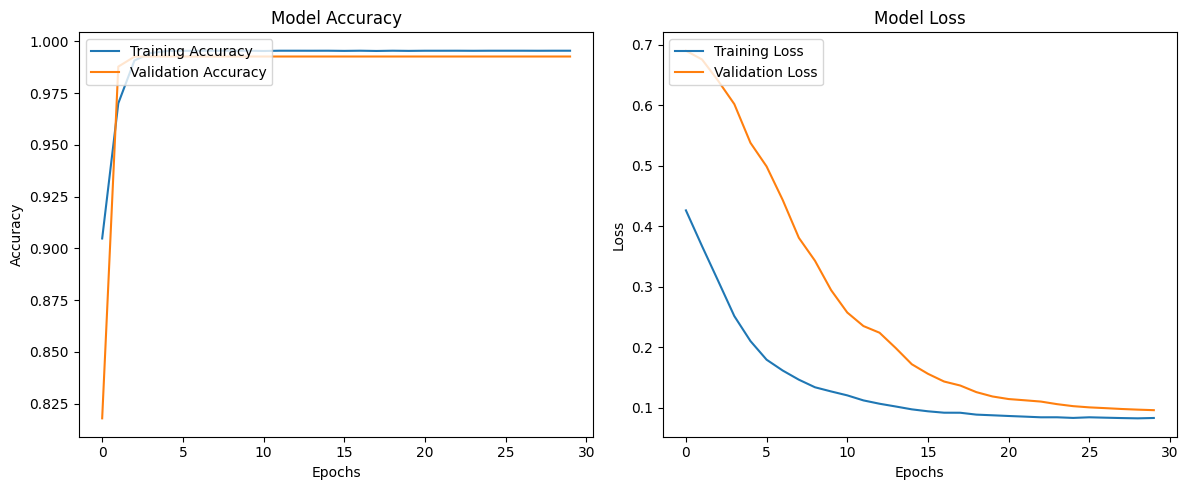

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and stored the training history in 'history'

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Adjust layout to make the plots fit better
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 479ms/step


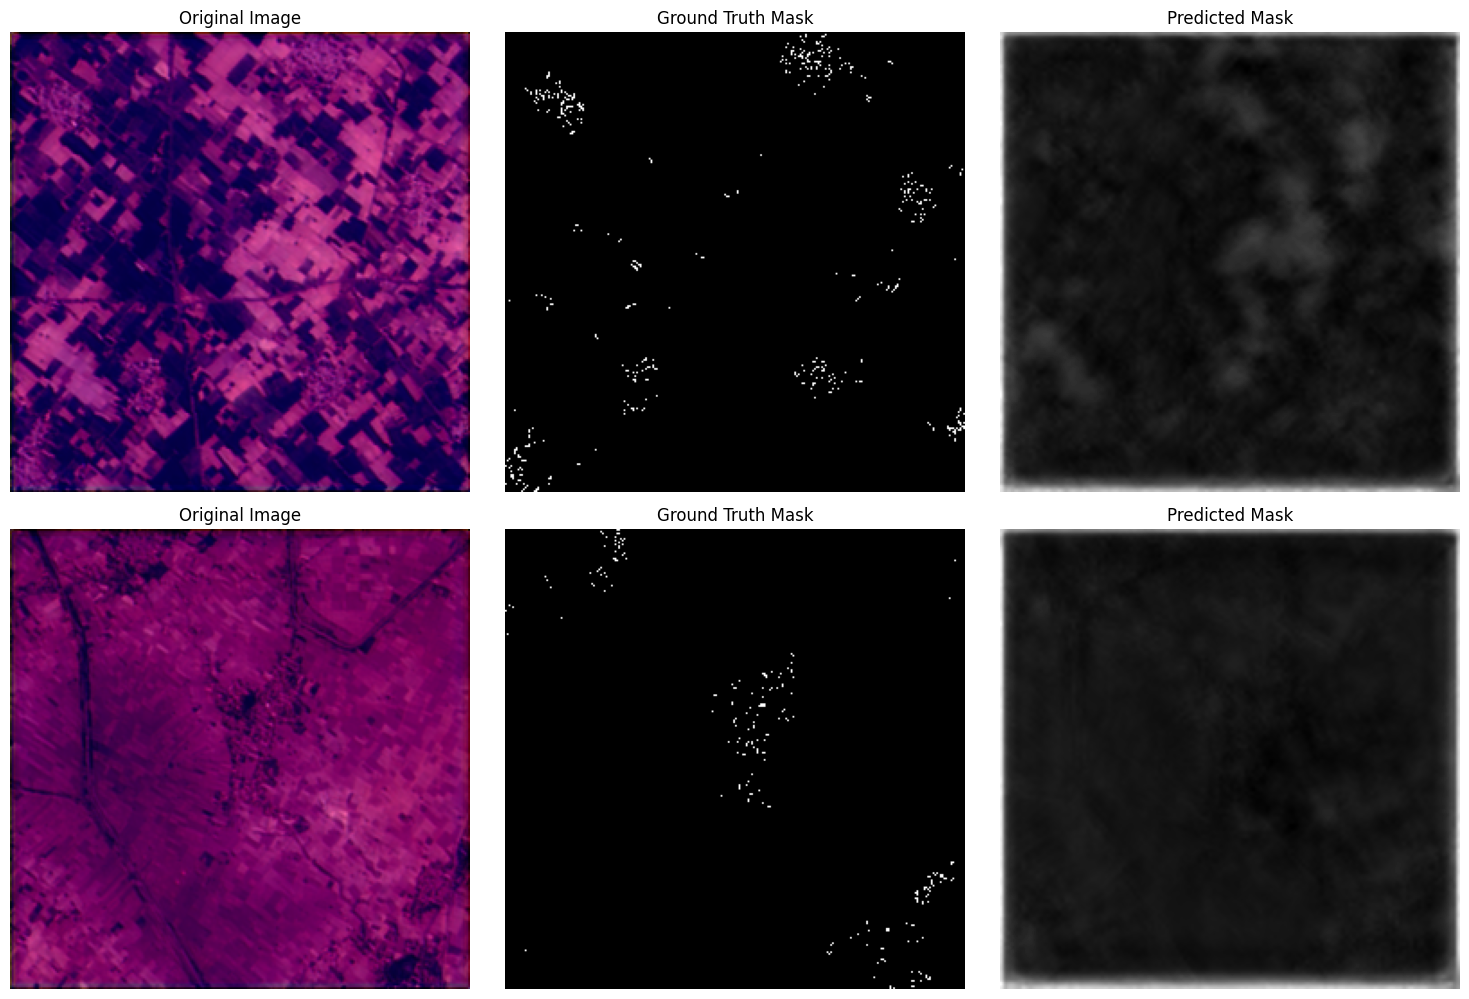

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Visualize samples from validation dataset
def visualize_samples(dataset, num_images=5, model=None):
    plt.figure(figsize=(15, num_images * 5))

    for i, (images, masks) in enumerate(dataset.take(num_images)):
        # Get the image and mask
        image = images[0].numpy()
        mask = masks[0].numpy().squeeze()

        # Predict mask if model is provided
        pred_mask = None
        if model is not None:
            pred_mask = model.predict(tf.expand_dims(image, axis=0))[0]
            pred_mask = pred_mask.squeeze()

        # Plot original image
        ax = plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(image)
        ax.set_title("Original Image", fontsize=12)
        plt.axis("off")

        # Plot ground truth mask
        ax = plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        ax.set_title("Ground Truth Mask", fontsize=12)
        plt.axis("off")

        # Plot predicted mask
        if pred_mask is not None:
            ax = plt.subplot(num_images, 3, i * 3 + 3)
            plt.imshow(pred_mask, cmap='gray')
            ax.set_title("Predicted Mask", fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call visualization function
visualize_samples(val_dataset, num_images=5, model=model)


In [ ]:
# Load weights from the last session
model.load_weights('/content/drive/MyDrive/full_data/sim_unet_checkpoint_epoch1_30.h5')  # Change this to the last saved checkpoint

# Re-define the callbacks (since they were defined inside a function)
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# ... (your cosine_lr_scheduler and other functions) ...

# Hyperparameters
batch_size = 4
total_epochs = 30 + 30 #  add 30 for the resume session
initial_learning_rate = 0.0001

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=1.0)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(
    lambda epoch: cosine_lr_scheduler(epoch, total_epochs, initial_learning_rate)
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    lr_schedule,
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/full_data/sim_unet_checkpoint_epoch1_{epoch}.h5',  # Save weights by epoch
        save_weights_only=True,
        save_best_only=False
    )
]


# Resume training
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,  # Total epochs for this session (previous + current)
    initial_epoch=30,  # Start from the last completed epoch
    callbacks=callbacks
)

Epoch 31/60
9/9 [==============================] - 51s 6s/step - loss: 0.0822 - accuracy: 0.9954 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0090 - val_loss: 0.0923 - val_accuracy: 0.9926 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0125 - lr: 5.0000e-05
Epoch 32/60
9/9 [==============================] - 51s 6s/step - loss: 0.0809 - accuracy: 0.9953 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0093 - val_loss: 0.0898 - val_accuracy: 0.9926 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0126 - lr: 4.7383e-05
Epoch 33/60
9/9 [==============================] - 51s 6s/step - loss: 0.0809 - accuracy: 0.9954 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0089 - val_loss: 0.0986 - val_accuracy: 0.9926 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0129 - lr: 4.4774e-05
Epoch 34/60
9/9 [==============================] - 51s 6s/step - loss: 0.0807 - accuracy: 0.9954 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0091 - val_loss: 0.1064 - val_accuracy: 0.9926 - val_mean_io_u_1: 0.4963 

1/1 [==============================] - 0s 439ms/step


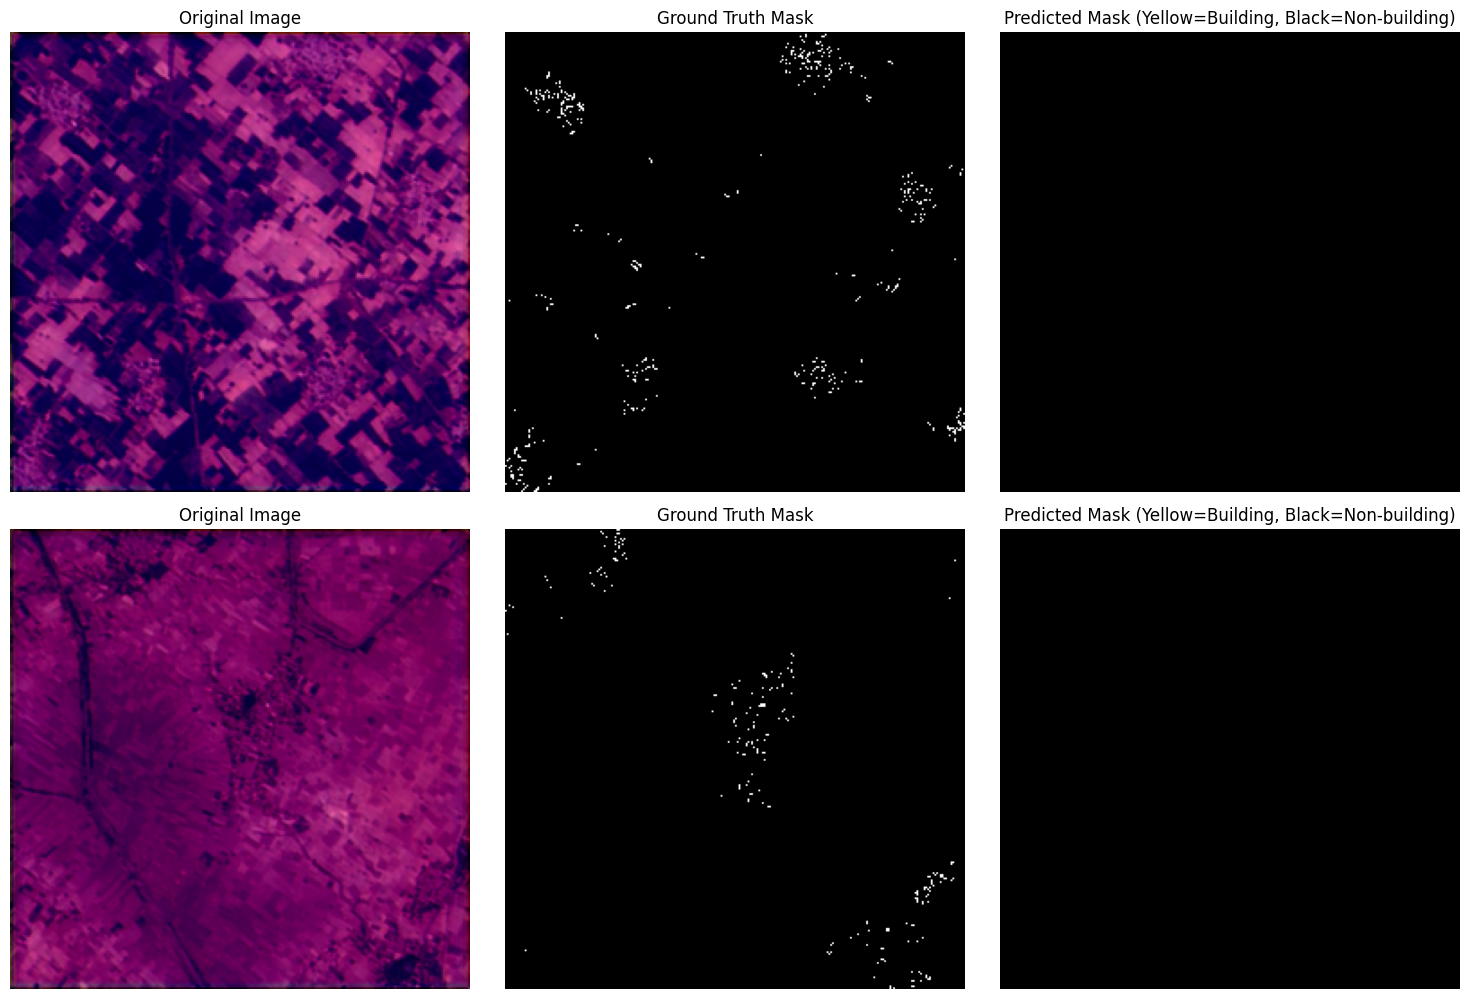

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.colors import ListedColormap

# Custom colormap: Yellow for buildings (1), Black for non-buildings (0)
cmap_custom = ListedColormap(['black', 'yellow'])

# Visualize samples from validation dataset
def visualize_samples(dataset, num_images=5, model=None, threshold=0.5):
    plt.figure(figsize=(15, num_images * 5))

    for i, (images, masks) in enumerate(dataset.take(num_images)):
        # Get the image and mask
        image = images[0].numpy()
        mask = masks[0].numpy().squeeze()

        # Predict mask if model is provided
        pred_mask = None
        if model is not None:
            pred_mask = model.predict(tf.expand_dims(image, axis=0))[0]
            pred_mask = (pred_mask.squeeze() > threshold).astype(int)  # Apply threshold to create binary mask

        # Plot original image
        ax = plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(image)
        ax.set_title("Original Image", fontsize=12)
        plt.axis("off")

        # Plot ground truth mask
        ax = plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        ax.set_title("Ground Truth Mask", fontsize=12)
        plt.axis("off")

        # Plot predicted mask
        if pred_mask is not None:
            ax = plt.subplot(num_images, 3, i * 3 + 3)
            plt.imshow(pred_mask, cmap=cmap_custom)
            ax.set_title("Predicted Mask (Yellow=Building, Black=Non-building)", fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call visualization function
visualize_samples(val_dataset, num_images=5, model=model, threshold=0.5)


1/1 [==============================] - 0s 420ms/step


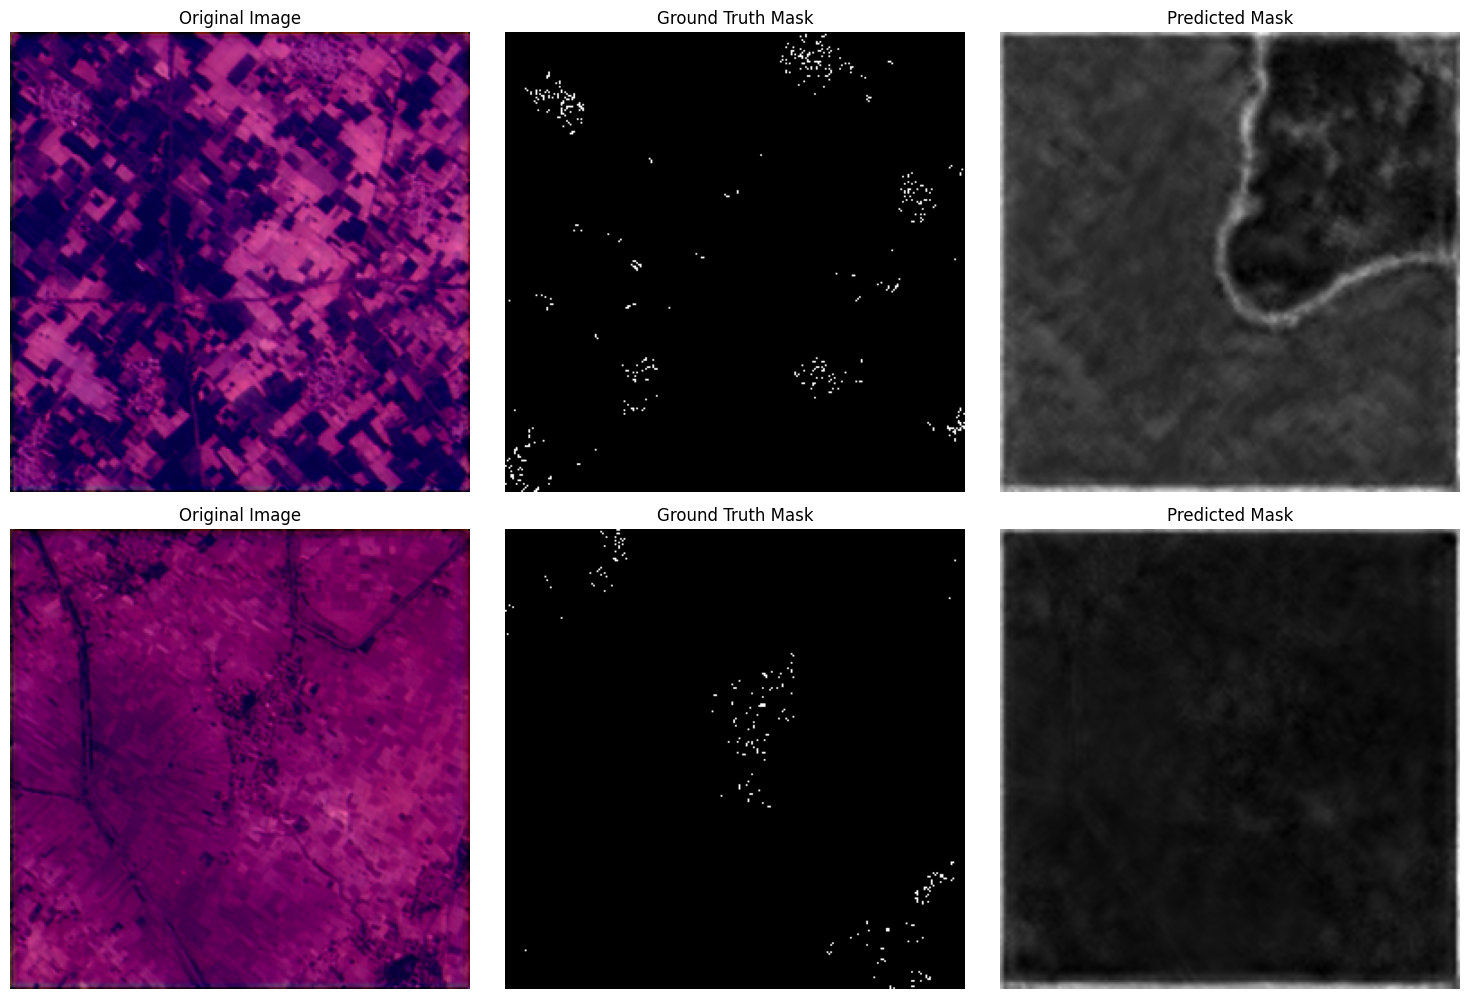

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Visualize samples from validation dataset
def visualize_samples(dataset, num_images=5, model=None):
    plt.figure(figsize=(15, num_images * 5))

    for i, (images, masks) in enumerate(dataset.take(num_images)):
        # Get the image and mask
        image = images[0].numpy()
        mask = masks[0].numpy().squeeze()

        # Predict mask if model is provided
        pred_mask = None
        if model is not None:
            pred_mask = model.predict(tf.expand_dims(image, axis=0))[0]
            pred_mask = pred_mask.squeeze()

        # Plot original image
        ax = plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(image)
        ax.set_title("Original Image", fontsize=12)
        plt.axis("off")

        # Plot ground truth mask
        ax = plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(mask, cmap='gray')
        ax.set_title("Ground Truth Mask", fontsize=12)
        plt.axis("off")

        # Plot predicted mask
        if pred_mask is not None:
            ax = plt.subplot(num_images, 3, i * 3 + 3)
            plt.imshow(pred_mask, cmap='gray')
            ax.set_title("Predicted Mask", fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call visualization function
visualize_samples(val_dataset, num_images=5, model=model)


In [ ]:
# Load weights from the last session
model.load_weights('/content/drive/MyDrive/full_data/sim_unet_checkpoint_epoch1_59.h5')  # Change this to the last saved checkpoint

# Re-define the callbacks (since they were defined inside a function)
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# ... (your cosine_lr_scheduler and other functions) ...

# Hyperparameters
batch_size = 4
total_epochs = 30 + 30 + 30 #  add 30 for the resume session
initial_learning_rate = 0.0001

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=1.0)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(
    lambda epoch: cosine_lr_scheduler(epoch, total_epochs, initial_learning_rate)
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    lr_schedule,
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/full_data/sim_unet_checkpoint_epoch2_{epoch}.h5',  # Save weights by epoch
        save_weights_only=True,
        save_best_only=False
    )
]


# Resume training
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,  # Total epochs for this session (previous + current)
    initial_epoch=60,  # Start from the last completed epoch
    callbacks=callbacks
)

Epoch 61/90
9/9 [==============================] - 51s 6s/step - loss: 0.0693 - accuracy: 0.9954 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0091 - val_loss: 0.0719 - val_accuracy: 0.9926 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0126 - lr: 2.5000e-05
Epoch 62/90
9/9 [==============================] - 51s 6s/step - loss: 0.0693 - accuracy: 0.9954 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0095 - val_loss: 0.0712 - val_accuracy: 0.9926 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0126 - lr: 2.3504e-05
Epoch 63/90
9/9 [==============================] - 51s 6s/step - loss: 0.0687 - accuracy: 0.9954 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0093 - val_loss: 0.0701 - val_accuracy: 0.9926 - val_mean_io_u_1: 0.4963 - val_dice_coefficient: 0.0126 - lr: 2.2040e-05
Epoch 64/90
9/9 [==============================] - 52s 6s/step - loss: 0.0683 - accuracy: 0.9954 - mean_io_u_1: 0.4977 - dice_coefficient: 0.0096 - val_loss: 0.0701 - val_accuracy: 0.9926 - val_mean_io_u_1: 0.4963 